# Dataloaders and Datasets
pytorch提供2种data primitives来pre-load数据集：torch.utils.data.DataLoader和torch.utils.data.Dataset。 \
(1) Dataset存放samples和对应的labels。 \
(2) Dataloader则是将Dataset wrap成一个iterable以便access samples

### Dataloaders
torch.utils.data.DataLoader本质上是batches的管理工具，其作用是方便iterate over batches。

### Datasets
1. pytorch的libraries提供了一些pre-load好的数据集（语音、图片、文字、视频）。这些数据集都是torch.utils.data.Dataset的subclass\
  (1) image放在名为torchvision.datasets的module中\
  (2) audio放在名为torchaudio.datasets的module中
2. 这些数据集都都有类似的API，他们都有transform和target_transform两个参数分别用来对input和target做变换
3. 可以用base classes来创建自己的数据集。有3类base class：\
  (1) DatasetFolder: A generic data loader\
  (2) ImageFolder: A generic data loader for images\
  (3) VisionDataset: for making datasets compatible with torchvision

## 1. Loading a Dataset
**Fashion-MNIST: 电商网站zalando的商品图片**\
· TorchVision中的数据集\
· 60000个训练样本，10000个test sample，每张图是一个28x28的灰度图片

In [1]:
# load the Fashion-MNIST dataset from TorchVision
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt


training_data = datasets.FashionMNIST(
    root="data",          # 数据存储的path
    train=True,           # 指定trainmode
    download=True,        # 如果root指定的位置没有数据，就从网上下载
    transform=ToTensor()  # 指定feature和label transform的规则
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,          # 指定test mode
    download=True,
    transform=ToTensor()
)

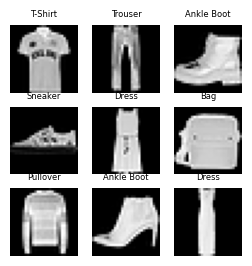

In [2]:
# 手动加label，并画图
labels_map = {
    0: "T-Shirt",  1: "Trouser",
    2: "Pullover", 3: "Dress",
    4: "Coat",     5: "Sandal",
    6: "Shirt",    7: "Sneaker",
    8: "Bag",      9: "Ankle Boot",
}
figure = plt.figure(figsize=(3, 3))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item() # 从training data抽1个样本
    img, label = training_data[sample_idx]                           # 拿到sample和label
    figure.add_subplot(rows, cols, i)                                # 画图
    plt.title(labels_map[label], size=6)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

## 2. 创建自有数据集
(1)都要定义成Dataset class的subclass\
(2)必须有\__init__，\__len__，\__getitem__三个method

In [3]:
## 以FashionMNIST为例
# images存在名为img_dir的目录中，labels存在名为annotations_file的csv文件中

**label csv 文件内容格式：**\
tshirt1.jpg, 0\
tshirt2.jpg, 0\
......\
ankleboot999.jpg, 9

In [4]:
import os
import pandas as pd
from torchvision.io import read_image

class RKImageData(Dataset):                             # 用Dataset作为parent class
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file) # annotations_file是csv格式的label文档
        self.img_dir = img_dir                          # img_dir是存放images的目录
        self.transform = transform                      # 要有transform和target_transform两个参数
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_name = self.img_labels.iloc[idx, 0]         # 从label文件中取image的图片名
        img_path = os.path.join(self.img_dir, img_name) # 用image的图片名从image文件夹中取path
        image = read_image(img_path)                    # 用path读取image data，转变成tensor类型数据
        label = self.img_labels.iloc[idx, 1]            # 从label文件中取image的label值
        if self.transform:               
            image = self.transform(image)               # 用transform处理image原始数据
        if self.target_transform:               
            label = self.target_transform(label)        # 用target_transform处理label原始数据  
        return image, label

## 3. 准备训练数据
**为什么用Dataloader：**\
训练模型时的数据处理需求：\
(1)用Dataset的getitem的话，一次只能取一个数据，而训练过程中，通常一次取一个Batch。\
(2)每个epoch要reshuffle整个dataset来降低overfitting\
(3)使用python的multiprocessing来加速data retrieval\
Dataloader提供了上述三个功能的API，并且wraps dataset to a iterable.

In [5]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

**用Dataloader做迭代**\
下面每次iteration返回a batch of train_features和train_labels

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


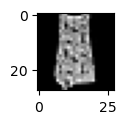

Label: 6


In [6]:
# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze() # squeeze()消除对象shape中值为1的维度，这里从(1, 28, 28)变成(28, 28)
label = train_labels[0]
figure = plt.figure(figsize=(1, 1))
plt.imshow(img, cmap="gray")      # 只接受(m, n), (m, n, 3), (m, n, 4)三种维度的图
plt.show()
print(f"Label: {label}")

## 4. Transforms
Transforms package提供了预处理数据和执行data augmentation的工具。

In [8]:
import torch
from torchvision import datasets
import torchvision.transforms as T

ds = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=T.ToTensor(),  # 把PIL image或者numpy ndarray转变成FloatTensor类型的数据
    target_transform=T.Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))
    # lambda的作用是创建one-hot label：turn the integer into a one-hot encoded tensor
    # 新建长度10的zero tensor，scatter将value=1放到index given by y
)

In [9]:
## 构建transform组合
data_mean = 0  # 只是实例，实际需要根据case计算
data_var = 0

transform = T.Compose([
    T.ToTensor(), 
    T.Normalize(data_mean, data_var)
])